# Exploration: DEQ Drinking Water Data

This data comes from the Utah DEQ. We have chemical measurements on the following substances: 

| Known Carcinogens | Probable Carcinogens | Possible Carcinogens |
|------|------|------|
|Arsenic|Dichloromethane|Carbon Tetrachloride|
|Asbestos|Ethyl Dibromane|Chlordane|
|Benzene|Glyphosate|Dichloroethane|
|Beryllium|Styrene|Ethyl Benzene|
|Cadmium|Sulfate|Heptachlor|
|Rad-226|Tetrachlorethane|Hexchlorobenzene|
|Rad-228 (Waiting on DEQ)||Pentachlorophenol|
|Dioxin||Toxaphene|
|Gross Alpha, Excl. Rad and U|||
|Gross Alpha, inc. Rad and U|||
|Lead|||
|Nitrate|||
|PCB|||
|Radon|||
|Trichlorethylene|||
|Uranium|||
|Vinyl Choloride|||
|1,2 Dichloropropane|||
|Benzo(A)Pyrene|||
|Vinyl Choloride|||
|Pentachlorophenol|||

All data is in seperate .xcel files of different length, containing a varied number of measurements over time. To preserve privacy, the facility names, not addresses, are used to describe location. Merging with information from the DEQ interactive map may yield these point locations. 

## Test: Merge Nitrate Locations with Facility Name from DEQ Map - Completeness of Overlap

Nitrate data is the largest of all downloaded drinking water. Merging unique facility names on top of the DEQ supplied facility names. If overlap is complete, this provides a method for adding point location to measurements of drinking water. 

In [1]:
#Libraries: 

#Basic py: 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import glob
import random
import base64
from PIL import Image
from io import BytesIO
from IPython.display import HTML
import io
import pdfkit

#Geo
import geopandas as gpd
import fiona
from shapely.geometry import Point
import descartes

In [92]:
#Import Data: Nitrate and Locations
path = 'C:\\Users\\u0890227\\Desktop\\DEQ_DW_Chem_Analysis\\'
nitrate_base = pd.read_csv(path + '\\Known_Carcinogens\\DW_CA_Nitrate.csv',header=0)

Update:
 - Geopandas is dependent on a file called gcs.csv in order to gather all the ESRI mappings. See more information here: https://trac.osgeo.org/gdal/wiki/FAQInstallationAndBuilding#WhatisGDAL_DATAenvironmentvariable 
 - Weirdly, the shape file from the DEQ seems to be mapped on EPSG codes which do not exist. 
 - Attempting this again in ARCgis to see if the mapping will align - User error
 - Downloaded from link and moved into this directory: move C:\Users\u0890227\Downloads\gcs.csv C:\Users\u0890227\anaconda3\envs\gis\Library\share\gdal
 
 - Update: Could not find a way to match the projections of the two files. Ended merging the two shapefiles in GIS then pulling back the new shape file. 
     - Projection Mapping Used: NAD 1983 UTM Zone 12 N

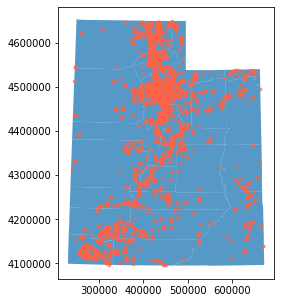

In [3]:
#Plotting the total number of facilities with known locations against the counties of Utah
Counties = gpd.read_file('Counties\Counties.shp')
fac_raw = gpd.read_file('C:\\Users\\u0890227\\Desktop\\DEQ_DW_Chem_Analysis\\DW_Fac_PNAD1983UTMZone12N')

fig,(ax) = plt.subplots(figsize=(5,5))
Counties.plot(ax=ax,alpha =0.75)
fac_raw.plot(ax=ax, color = 'tomato',alpha =0.6,markersize=7)

In [4]:
#Need to convert the Collection Dates to more ammenable form
nitrate_base['Collection_Date'] = pd.to_datetime(nitrate_base["Collection Date"])
print("The earliest collection date is: " + str(min(nitrate_base['Collection_Date'])))

The earliest collection date is: 1964-04-01 00:00:00


In [5]:
fac_raw.head()

,SYSFACID,FEDERALID,SYSNUMBER,SYSNAME,FACID,FACNAME,FACTYPECOD,FACTYPEDES,SOURCEFLAG,FACACTIVIT,...,LATITUDEDD,ELEVATIONM,ID,NAME,ADDRESS,CITY,TYPE,ENVIROAPPL,ENVIROAPPS,geometry
0,20024WS001,6245.0,20024,MAMMOTH GS - GOOSEBERRY CAMPGROUND,WS001,MAMMOTH SPRING,SP,Spring,Y,A,...,39.696022,0.0,20024WS001,MAMMOTH SPRING,20024,MAMMOTH GS - GOOSEBERRY CAMPGROUND,Spring,20024WS001,n/a,POINT (473250.343 4394066.705)
1,20025WS001,6246.0,20025,MANTI COMMUNITY CAMPGROUND,WS001,CAMPGROUND SPRING,SP,Spring,Y,A,...,39.248913,0.0,20025WS001,CAMPGROUND SPRING,20025,MANTI COMMUNITY CAMPGROUND,Spring,20025WS001,n/a,POINT (453166.317 4344540.325)
2,20033WS001,6249.0,20033,TWELVE MILE FLAT CAMPGROUND,WS001,TWELVE MILE SPRING,SP,Spring,Y,A,...,39.127326,0.0,20033WS001,TWELVE MILE SPRING,20033,TWELVE MILE FLAT CAMPGROUND,Spring,20033WS001,n/a,POINT (457931.731 4331019.650)
3,23008WS002,6242.0,23008,WENDOVER CITY WATER SYSTEM,WS002,MUNSEE SPRING,SP,Spring,Y,A,...,41.015339,0.0,23008WS002,MUNSEE SPRING,23008,WENDOVER CITY WATER SYSTEM,Spring,23008WS002,n/a,POINT (245582.039 4544871.177)
4,23008WS003,6243.0,23008,WENDOVER CITY WATER SYSTEM,WS003,NIELSON SPRING,SP,Spring,Y,A,...,41.016210,0.0,23008WS003,NIELSON SPRING,23008,WENDOVER CITY WATER SYSTEM,Spring,23008WS003,n/a,POINT (245564.033 4544968.627)


In [6]:
#Pull only the unique facility names and codes
nitrate = nitrate_base[['Facility Code','Facility Name','Collection_Date']].drop_duplicates(subset ="Facility Name")
facilities = fac_raw[['geometry','FACNAME']].drop_duplicates(subset ="FACNAME")

In [7]:
#Shape of Data: 
print('The Shape of the Original DEQ Data: ' + str(fac_raw.shape))
print('The Shape of the Unique DEQ Facilities: ' + str(facilities.shape))
print('The Shape of the Original Nitrate: ' + str(nitrate_base.shape))
print('The Shape of the Unique Nitrate Facilities: ' + str(nitrate.shape))

The Shape of the Original DEQ Data: (3189, 36)
The Shape of the Unique DEQ Facilities: (2542, 2)
The Shape of the Original Nitrate: (122623, 10)
The Shape of the Unique Nitrate Facilities: (3145, 3)


In [8]:
#Merge Data: Using inner joint aka drops all rows for which there is no agreement between nitrate and DEQ facility name
unique_facilities = pd.merge(left = nitrate, right =  facilities, left_on='Facility Name', right_on='FACNAME',how='inner')
total_data_overlap = pd.merge(left = nitrate_base[['Facility Code','Facility Name','Collection_Date']], 
                  right =  facilities, left_on='Facility Name', right_on='FACNAME',how='inner')


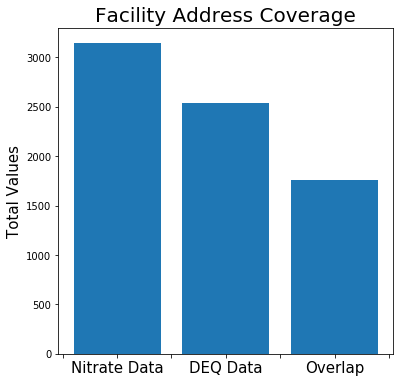

In [9]:
#In total there are ~2300 wells for which we have the lat long data for. This leaves approx. 800 wells without data. This 
#equates to roughly 20,000 measurements of roughly 120,000.

fig,(ax1) = plt.subplots(ncols=1,nrows=1)
fig.set_size_inches(6, 6)

my_xticks = ['','','Nitrate Data','', 'DEQ Data','','Overlap']

ax1.set_ylabel("Total Values",fontsize=15)
ax1.bar([0,1,2],[nitrate.shape[0],facilities.shape[0],unique_facilities.shape[0]])
ax1.set_xticklabels(my_xticks,fontsize=15)
ax1.set_title("Facility Address Coverage",fontsize=20)

plt.show()

In [64]:
#Earliest and Latest Collection Date: 
print("The earliest collection date is: " + str(min(total_data_overlap['Collection_Date'])))
print("The latest collection date is: " + str(max(total_data_overlap['Collection_Date'])))

The earliest collection date is: 1964-04-01 00:00:00
The latest collection date is: 2019-11-26 00:00:00


In [57]:
#Grab all Observations 
all_data = pd.merge(left = nitrate_base[['Facility Code','Facility Name','Collection_Date']], 
                  right =  facilities, left_on='Facility Name', right_on='FACNAME',how='outer')
all_data.shape

(123401, 5)

In [59]:
#Taking a deeper dive into the places which have no data or were not merged
Facility_missing = all_data.loc[all_data['Facility Name'].isnull()]
FACNAME_missing = all_data.loc[all_data['FACNAME'].isnull()]

print("The total number of facilities not matching any known water data is: %d" % Facility_missing.shape[0])
print("The total number of data points with unpaired/unknown facility is: %d" % FACNAME_missing.shape[0])

The total number of facilities not matching any known water data is: 778
The total number of data points with unpaired/unknown facility is: 42571


In [65]:
# Are these locations singular or are there reoccuring ones:
FACNAME_missing['Facility Name'].value_counts().head(20)

WELL #1                                     983
WELL #2                                     722
WELL #3                                     435
ATHERTON WEST WELL                          427
WELL #12                                    356
WELL #9                                     353
WELL 3                                      327
TAYLORSVLLE WEST WELL                       313
67 ARTESIAN WELL - ABANDONED                303
WELL # 15                                   303
WELL 2                                      302
SAMPLING STATION - 01 02                    286
WELL #5                                     285
WELL 1                                      263
NORTH WELL                                  260
WEST FORK WELL #2                           208
SAND HOLLOW WELL 1                          207
SAND HOLLOW WELL 8                          206
WELL #11                                    202
WELL #15                                    198
Name: Facility Name, dtype: int64

In [62]:
#Conclusion: Most of the missing nitrate data is coming from wells. This makes sense as this is what is 
#being protected and with held from the DEQ. 

## Repeat for all Known, Probable and Possible Carcinogens: 
What's the coverage: Location and Coverage?

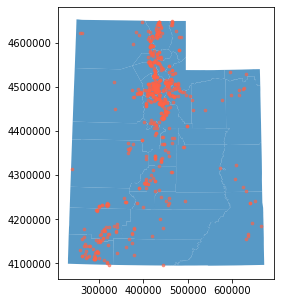

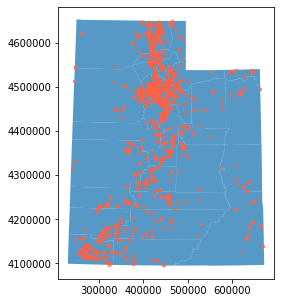

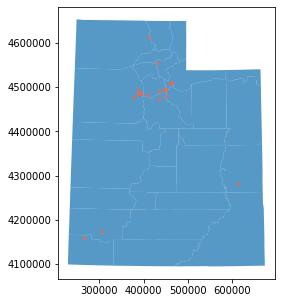

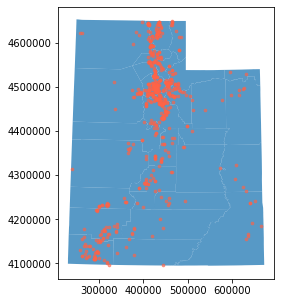

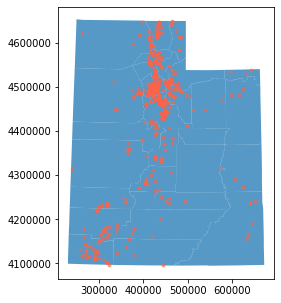

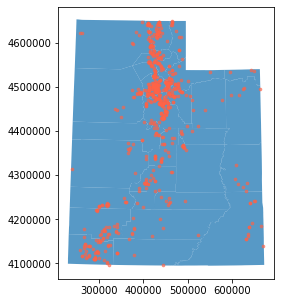

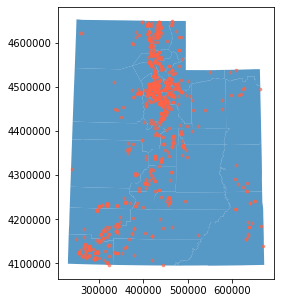

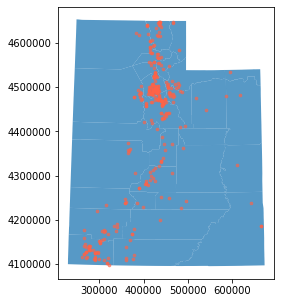

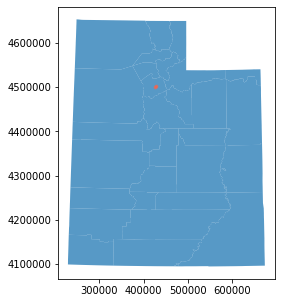

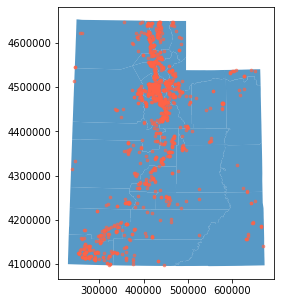

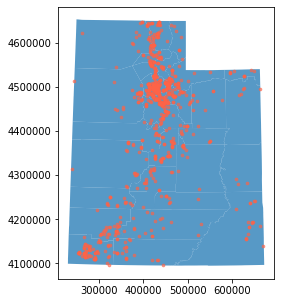

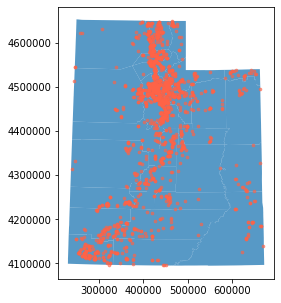

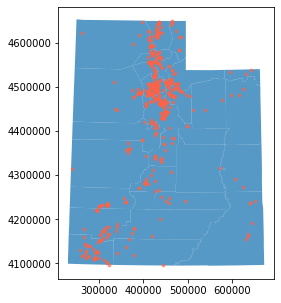

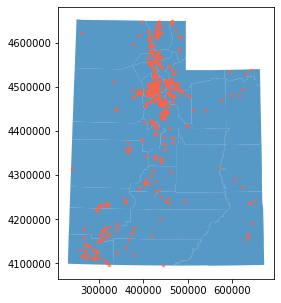

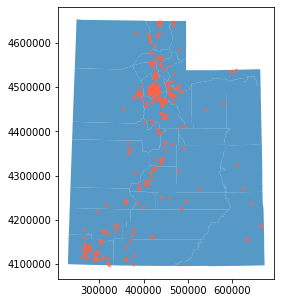

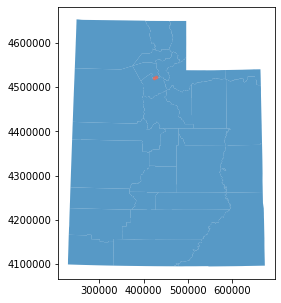

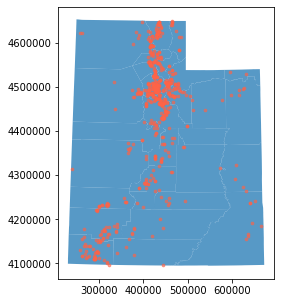

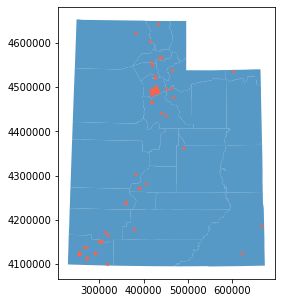

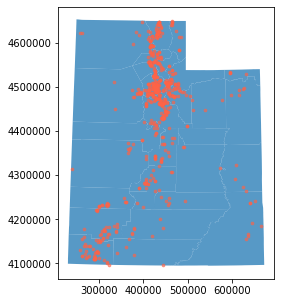

In [81]:
#Let's do the known carcinogens first: 
summary_df = pd.DataFrame(columns = ["Chemical","%_Fac_w_Address","Tot_Fac_w_Address", "%_Obs_With_Location","Total_Obs_w_Loc","Min_Date","Max_Date"]) 
facilities = gpd.read_file('C:\\Users\\u0890227\\Desktop\\DEQ_DW_Chem_Analysis\\DW_Fac_PNAD1983UTMZone12N')
uniq_facilities = facilities.drop_duplicates(subset ="FACNAME")
carc_path = path + '\\Known_Carcinogens\\'
path_known_carc = carc_path + '*.csv'
Miss_Loc_df = []

for fname in glob.glob(path_known_carc):
    chem_name = fname.split("_")[6].split(".csv")[0]
    chem_df = pd.read_csv(fname,header=0)
    
    #Organize the dates and times
    chem_df['Collection_Date'] = pd.to_datetime(chem_df["Collection Date"])
    
    #Gather Unique Facility Names
    chem_unique = chem_df.drop_duplicates(subset ="Facility Name")
    
    #Merge the facility locations with the measurment data: 
    fac_overlap = pd.merge(left = chem_unique, right = uniq_facilities,
                                 left_on='Facility Name', right_on='FACNAME',how='inner')
    total_overlap = pd.merge(left = chem_df, right =  uniq_facilities,
                                  left_on='Facility Name', right_on='FACNAME',how='inner')
    
    #Append all data which does not have locations into a larger dataframe
    all_data = pd.merge(left = chem_df[['Facility Code','Facility Name','Collection_Date']], 
                  right =  facilities, left_on='Facility Name', right_on='FACNAME',how='outer')
    FACNAME_missing = all_data.loc[all_data['FACNAME'].isnull()]
    Miss_Loc_df.append(FACNAME_missing)
    
    #Plotting
    fig,(ax) = plt.subplots(figsize=(5,5))
    Counties.plot(ax=ax,alpha =0.75)
    gdf = gpd.GeoDataFrame(fac_overlap)
    gdf.plot(ax=ax, color = 'tomato',alpha =0.6,markersize=7)
   # plt.savefig(chem_name + '.png')

    #Let's put things into the dataframe
    vals_temp = [chem_name,fac_overlap.shape[0]/chem_unique.shape[0],fac_overlap.shape[0],total_overlap.shape[0]/chem_df.shape[0],total_overlap.shape[0],
                 min(total_overlap['Collection_Date']),max(total_overlap['Collection_Date'])]
    keys_temp = ["Chemical","%_Fac_w_Address","Tot_Fac_w_Address", "%_Obs_With_Location","Total_Obs_w_Loc","Min_Date","Max_Date"] 

    df_temp = pd.DataFrame([vals_temp],columns =keys_temp )
    summary_df = summary_df.append(df_temp,ignore_index=True)

Miss_Loc_df = pd.concat(Miss_Loc_df)

In [90]:
summary_df

,Chemical,%_Fac_w_Address,Tot_Fac_w_Address,%_Obs_With_Location,Total_Obs_w_Loc,Min_Date,Max_Date
0,12Dichloropropane,0.508306,612,0.477995,2270,1988-12-19,2019-12-23
1,Arsenic,0.570947,1356,0.558638,12728,1969-03-10,2019-11-18
2,Asbestos,0.477273,21,0.446809,21,1995-06-01,2019-11-06
3,Benzene,0.511494,623,0.479197,2269,1990-06-18,2019-11-06
4,Benzo(A)Pyrene,0.512476,534,0.459985,1868,1993-09-14,2019-12-26
5,Beryllium,0.532710,684,0.475043,1675,1993-08-20,2019-11-07
6,Cadmium,0.561783,882,0.527868,2434,1975-06-19,2019-11-07
7,CombRad226228,0.522124,354,0.552842,1177,1981-09-16,2019-10-01
8,Dioxin,0.333333,2,0.333333,2,2004-08-27,2004-08-27
9,GroAExclRU,0.593868,1259,0.652910,11074,1960-06-18,2019-10-17


In [85]:
Miss_Loc_df['Facility Name'].value_counts().head(20)

WELL #1                                     1520
WELL #2                                     1011
SAMPLING STATION - 01 02                     707
ATHERTON WEST WELL                           700
WELL #3                                      678
TAYLORSVLLE WEST WELL                        575
SAMPLING STATION - 01, 02                    542
WELL 1                                       475
WELL 3                                       468
WELL #12                                     433
WELL #9                                      429
WELL #5                                      405
WELL 2                                       395
NORTH WELL                                   394
SAND HOLLOW WELL 8                           382
67 ARTESIAN WELL - ABANDONED                 345
WELL # 15                                    345
TOWN WELL                                    343
WELL # 1                                     334
LITTLE VALLEY CG SPRING                      327
Name: Facility Name,

In [ ]:
#Move all images to file: DW_Fac_Maps_Merged within Desktop DEQ_DW Folder first!

#Create Path to Data: 
path_images = path + '\\DW_Fac_Maps_Merged\\*.png'
images = []
for fname in glob.glob(path_images):
    images.append(fname)
summary_df['images'] = images

#Functions for adding images via HTML
pd.set_option('display.max_colwidth', -1)
def get_thumbnail(path):
    path = path # This "\\\\?\\" is used to prevent problems with long Windows paths
    i = Image.open(path)    
    return i

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'png')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return f'<img src="data:image/png;base64,{image_base64(im)}">'

#Create Dataframe with PIL HTML Images
summary_df['Images'] = summary_df.images.map(lambda f: get_thumbnail(f))
summary_df = summary_df.drop(columns ='images')
summary_df

In [ ]:
#Save HTML File
merged_HTML = HTML(summary_df.to_html(formatters={'Images': image_formatter}, escape=False))
html = merged_HTML.data
with open('DW_Merge.html', 'w') as f:
    f.write(html)

In [ ]:
merged_HTML

## Findings Summary:

In this notebook I process and analyze the drinking water data from the DEQ DW Portal.

**Pre-Processing**
<br>From the DEQ DW Portal - I collected all water data on known, probable and possible carcinogens based upon the 2019 IARC list of carcinogens. All collected data files are displayed in the chart at the beginning of this file. Upon download, it was realized that no data carried an identifier.

<br>In an attempt to get locations, water well and facility locations were pulled from the DEQ interactive map. This led to a secondary set - a group of facilities and geocoded locations. 

**Data Wrangling**
<br> The nitrate dataset was explored as a test case. Once quantifications were solidified and methodology tested, the remaining **known** carcinogens were tested. The following describes the steps that were taken to analyze the breadth of the data.  

<br> Collected facilities and quantified measurements were merged based upon the nomenclature of the facility. This takes the form FACNAME for the DEQ interactive map and Facility Name for the quantified DW water set. Once merged, the remainder of the quantifications, lacking locations were appended and examined. Next, overlapping data was quantified, both numerically and geographically. All resorts were exported to HTML then pdf for ease of sharing.

**Results**
<br> 
1. DW quantifications lacking locations are predominantly wells. This is expected as the DEQ is keeping many private wells hidden. 
2. The mean coverage is ~50% for data entries which have location as a percentage of the total number of data entries (mirrored by the number of unique facilities which have location)\
3. Spread is greatest along the I-15 corridor for geographical location.\
4. Min collections date vary greatly by chemical (1964 to 2014). All chemicals contain max collection dates in 2019. 

**Looking Forward**
<br> 
1. Get data from DEQ DW.
2. Decide on Carcinogens